In [10]:
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from cycler import cycler

from scipy.optimize import minimize_scalar, brute
import scipy.optimize as optimize

%matplotlib inline

In [11]:
plt.style.use('seaborn-whitegrid')
img_path = "../reports/figures/"

In [12]:
# Task of interest
MU = 1.0
SIGMA = 1.0  # All formulas assume SIGMA=1.0, Do not change this value
P = 0.8

# The bias toward the class +MU if p > 0.5

In [13]:
def get_cdf(a, mean, std):
    a_norm = (a - mean) / std
    return norm.cdf(a_norm)

def err_h(h):
    # This is the error of a single hypothesis 'h'
    err = P * get_cdf(h, MU, SIGMA) + (1 - P) * (1 - get_cdf(h, -MU, SIGMA))
    err = np.round(err * 100, 4)
    return err

In [14]:
def create_dataset(samples, delta, mu):
    n_x1 = int(np.round(samples * P))
    n_x0 = int(np.round(samples * (1 - P)))
    
    if n_x1 == 0 and n_x0 == 0:
        return 0, 0
    if n_x1 == 0 or n_x0 == 0:
        raise RuntimeError
    
    x0 = np.random.normal(-mu + delta, SIGMA, size=n_x0)
    x1 = np.random.normal(mu + delta, SIGMA, size=n_x1)
    return x0, x1

In [19]:
nrounds = 1000
nval = 10
mvals = [0, 5, 10, 15, 20, 30, 50]
mnorm = [m / nval for m in mvals]
dlist = [0, 0.1, 10]
all_errs = []

for delt in dlist:
    merr = []

    for m in mvals:
        errs = []
        for it in range(nrounds):
            x_t = create_dataset(nval, 0.0, MU)
            x_ood = create_dataset(m, delt, MU)

            x_0m = 0.5 * (np.mean(x_t[0]) + np.mean(x_ood[0]))
            x_1m = 0.5 * (np.mean(x_t[1]) + np.mean(x_ood[1]))

            x_mid = 0.5 * (np.mean(x_t[0]) + np.mean(x_t[1]))
            x_diff = (x_1m - x_0m)

            h = x_mid + (SIGMA**2 * np.log ( (1 - P) / P)) / x_diff
            errs.append(err_h(h))
        merr.append((np.mean(errs), np.std(errs)))
    all_errs.append(merr)

    print("Delta=" + str(delt))
    for m in merr:
        print(m)                       

Delta=0
(15.229235799999998, 5.625984659449256)
(12.6273227, 3.5426621430634206)
(12.271195599999999, 1.4675882947273189)
(12.1683133, 1.390199054011011)
(12.1151562, 1.2765196573110655)
(12.0125397, 1.185863767046582)
(12.010066299999998, 1.1764177753818197)
Delta=0.1
(15.117934499999999, 5.225754961057755)
(12.5823439, 3.4596287236729304)
(12.305267599999999, 2.5784458746869676)
(12.196424899999998, 2.4848217253215554)
(12.1281906, 1.3113980533124334)
(12.043592, 1.1470333081371262)
(12.0772804, 1.1663400596206237)
Delta=10
(15.060776399999998, 5.265374206740016)
(12.705292699999998, 3.5466823100182947)
(12.1509899, 1.3985007217402465)
(12.1770774, 1.4712520606100232)
(12.0531061, 1.3068482999846578)
(12.035596600000002, 1.153807077473717)
(12.0371649, 1.185502100435925)


In [20]:
def make_loss_plot(errs, fname):
    fig = plt.figure(figsize=(5,3))
    color_idx = np.linspace(0, 1, len(dlist))
    
    for i in range(len(dlist)):
        col = plt.cm.RdYlGn_r(color_idx[i])
        err = np.array(errs[i])[:, 0]
        std = np.array(errs[i])[:, 1]
        plt.plot(mnorm, err, color=col)
        #plt.scatter(mnorm, err, alpha=0.5, s=5, color=col)
        #plt.errorbar(mnorm, std, color=col, capsize=4, capthick=1)
        markers, caps, bars = plt.errorbar(mnorm, err, std, color=col,  capsize=3, capthick=1)
        [bar.set_alpha(0.2) for bar in bars]

    plt.legend([str(d) for d in dlist], title='Delta', bbox_to_anchor = (1.05, 1.0))

    plt.xlabel("m/n, n=" + str(nval))
    plt.ylabel("Avg Risk")

    plt.savefig(img_path + fname, bbox_inches="tight")
    plt.show()
    

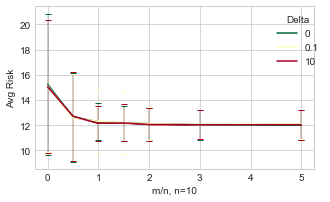

In [21]:
make_loss_plot(all_errs, "03-rr-multihead_class_priors.pdf")

In [33]:
nrounds = 10000
nval = 10
mvals = [0, 5, 10, 15, 20]
mnorm = [m / nval for m in mvals]
mlist = [0, 0.1, 0.2, 1.0, 2.0, 5.0, 10.0]
all_errs = []

for mu in mlist:
    merr = []

    for m in mvals:
        errs = []
        for it in range(nrounds):
            x_t = create_dataset(nval, 0.0, MU)
            x_ood = create_dataset(m, 0.0, mu)

            x_0m = 0.5 * (np.mean(x_t[0]) + np.mean(x_ood[0]))
            x_1m = 0.5 * (np.mean(x_t[1]) + np.mean(x_ood[1]))

            x_mid = 0.5 * (np.mean(x_t[0]) + np.mean(x_t[1]))
            x_diff = (x_1m - x_0m)

            h = x_mid + (SIGMA**2 * np.log ( (1 - P) / P)) / x_diff
            errs.append(err_h(h))
        merr.append((np.mean(errs), np.std(errs)))
    all_errs.append(merr)

    print("Mu=" + str(mu))
    for m in merr:
        print(m)                       

Mu=0
(15.157407760000002, 5.7927436455437755)
(19.461675959999997, 16.777710054465004)
(17.27808048, 12.661218854509583)
(16.391832620000002, 10.158625291348624)
(16.117934910000002, 9.572732489099353)
Mu=0.1
(15.11576985, 5.649849334506893)
(17.545295260000003, 14.048982099766642)
(15.88538528, 10.251786884285261)
(15.31010856, 8.324167978631062)
(15.02963056, 7.581156876894982)
Mu=0.2
(15.046691220000001, 5.26558860632322)
(16.7161821, 12.934635285676347)
(14.96427304, 8.49804229566923)
(14.383318060000002, 6.497469155425197)
(14.26217759, 6.179938108855848)
Mu=1.0
(15.1284546, 5.760326320318566)
(12.60737745, 2.998317816539217)
(12.233561439999999, 1.4960797195587963)
(12.160402289999999, 1.3529178225663805)
(12.10760254, 1.2888828889637525)
Mu=2.0
(15.06542964, 5.351255202088522)
(12.84614151, 2.4530388839319115)
(12.83038591, 2.4425041451470397)
(12.86807853, 2.437149000959531)
(12.83053199, 2.4440148901972014)
Mu=5.0
(15.078284739999999, 5.76016755316728)
(14.80004962, 4.30229377

In [38]:
def make_loss_plot_v2(errs, fname):
    fig = plt.figure(figsize=(5,3))
    color_idx = np.linspace(0, 1, len(mlist))
    
    for i in range(1, len(mlist)):
        col = plt.cm.RdYlGn_r(color_idx[i])
        err = np.array(errs[i])[:, 0]
        std = np.array(errs[i])[:, 1]
        plt.plot(mnorm, err, color=col)
        markers, caps, bars = plt.errorbar(mnorm, err, std, color=col,  capsize=3, capthick=1)
        [bar.set_alpha(0.2) for bar in bars]

    plt.legend([str(d) for d in mlist[1:]], title='Mu', bbox_to_anchor = (1.05, 1.0))

    plt.xlabel("m/n, n=" + str(nval))
    plt.ylabel("Avg Risk")

    plt.savefig(img_path + fname, bbox_inches="tight")
    plt.show() 

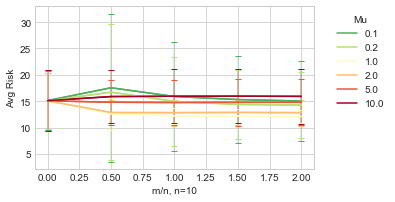

In [39]:
make_loss_plot_v2(all_errs, "03-rr-multihead_class_priors_mu2.pdf")